## Plan for unsupervised clustering

- [ ] Use clustering methods to see if can detect intent in labelled dataset
    - [ ] k-means
    - [ ] UMAP
- [ ] Follow advice for auto-generation of labels (for labelled dataset)
    - [ ] 2-stage semantic clustering and auto-labeling https://arxiv.org/pdf/2104.12114.pdf
    - [ ] hierarchical topic clustering https://aclanthology.org/R19-1108.pdf 
- [ ] Choose best to find unique clusters in pos/neutral unlabeled dataset
    - [ ] Auto-generation of labels
    - [ ] Manual labelling (semi-supervised)
        - Text summarization?
        - What categories should we do? 
            - maybe some combination of checking common labels for customer service stuff in literature / some statistics of types / copy the themes of the negative labels / we can just brainstorm


In [3]:
!pip install gensim

In [81]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize

In [159]:
import re
#import contractions

def clean_airline(x):
    x = x.lower() # convert to all lower case
    # x = re.sub('http\S+', '', x) # remove URLs
    # x = re.sub('<.*?>', '', x) # remove HTML tags
    #x = contractions.fix(x) # expand contractions
    x = re.sub('[^a-z]', ' ', x) # remove non-alphabetic characters
    x = re.sub('\s+', '', x) # remove whitespace
    return x

In [93]:
data_path = "../data/"

intent = pd.read_csv(data_path + "intent_Tweets.csv", index_col=0)

In [185]:
stopwords_eng = set(stopwords.words('english'))
intent['airline'] = intent['airline'].apply(clean_airline)
airline_long = [word+'air' for word in intent.airline.unique()]

stopwords_eng = set(stopwords.words('english'))
stopwords_eng.update(intent.airline.unique())
stopwords_eng.update(airline_long)

In [187]:
def remove_stopwords(text):
    
    clean = ' '.join([word for word in text.split(' ') if word not in stopwords_eng])
    return clean

In [188]:
print(intent.text[0])
print(remove_stopwords((intent.text[0])))

 really aggressive blast obnoxious entertainment guests faces amp little recourse
 really aggressive blast obnoxious entertainment guests faces amp little recourse


In [189]:
intent['text'] =  intent['text'].apply(remove_stopwords)

In [190]:
intent['negativereason'].value_counts()

3    2910
2    1665
1    1190
7     847
5     724
0     580
4     529
6     481
9     178
8      74
Name: negativereason, dtype: int64

In [191]:
intent = intent[intent['negativereason'].notna()]
intent.reset_index(drop=True, inplace=True)
num_labels = len(intent.negativereason.unique())

rmap = {reason: i for i, reason in enumerate(intent.negativereason.unique())}
imap = {i: reason for reason, i in rmap.items()}

intent.negativereason = intent.negativereason.apply(lambda x: rmap[x])

In [192]:
vectorizer = TfidfVectorizer(min_df=5, max_df=.5)
X = vectorizer.fit_transform(intent.text)

In [193]:
# checking sparsity
print(f"{X.nnz / np.prod(X.shape):.3f}")

0.004


In [194]:
print(f"n_samples: {X.shape[0]}, n_features: {X.shape[1]}")

n_samples: 9178, n_features: 2072


### Simple visualization, using PCA in 2-dimensions

In [195]:
from sklearn.decomposition import TruncatedSVD

Clustering directly on the T-IDF vectorized data

In [196]:
#two_dim_tweets = PCA(n_components=2).fit(X)
kmeans_labels = KMeans(n_clusters=num_labels).fit_predict(X)

In [197]:
clf = TruncatedSVD(n_components=100)
Xpca = clf.fit_transform(X)

In [198]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()

In [199]:
print(f"Total variance explained: {np.sum(lsa[0].explained_variance_ratio_):.2f}")

Total variance explained: 0.28


In [200]:
kmeans_labels = KMeans(n_clusters=num_labels).fit_predict(Xpca)

In [218]:
reduced_data = TruncatedSVD(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4)
kmeans.fit(reduced_data)
h = 0.02

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [229]:
ix = np.where(intent['negativereason'] == 1)

In [239]:
reduced_data.take(ix, axis=0).shape

(1, 1190, 2)

In [241]:
reduced_data.take(ix, axis=0)[:, :, 0].shape

(1, 1190)

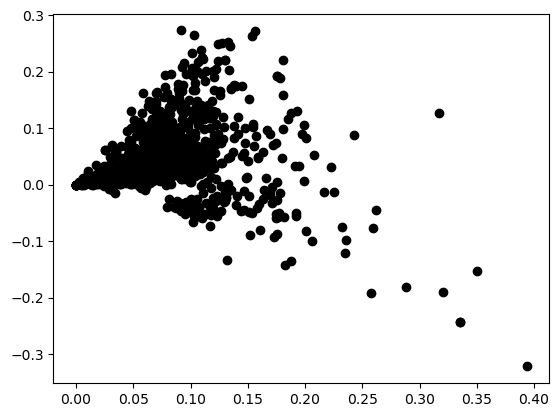

In [242]:
# Plot each category
plt.scatter(reduced_data.take(ix, axis=0)[:, :, 0], reduced_data.take(ix, axis=0)[:, :, 1], c="k")


(-0.6, 1.0)

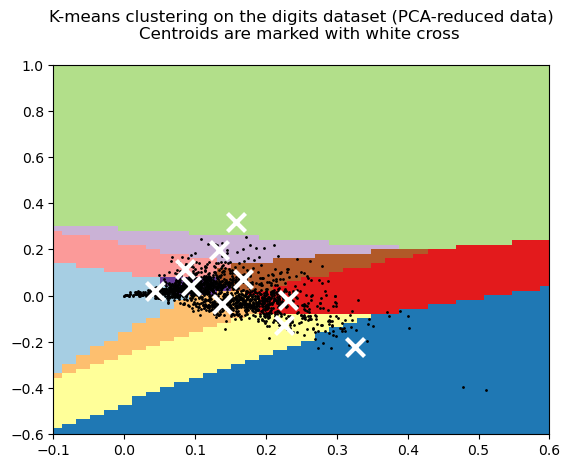

In [251]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

# Plot each category
#plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c="k", s=1)

# Plot one category
ix = np.where(intent['negativereason'] == 2)
plt.scatter(reduced_data.take(ix, axis=0)[:, :, 0], reduced_data.take(ix, axis=0)[:, :, 1], c="k", s=1)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross \n"
)
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.6, 1.0)

In [201]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [202]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=intent.negativereason)

kmeans = KMeans(init="random", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=intent.negativereason)

# pca = PCA(n_components=num_labels).fit(X)
# kmeans = KMeans(init=pca.components_, n_clusters=num_labels, n_init=1)
Xpca = TruncatedSVD(num_labels).fit(X)
kmeans = KMeans(init=Xpca.components_, n_clusters=num_labels, n_init=1)
bench_k_means(kmeans=kmeans, name="SVD-based", data=X, labels=intent.negativereason)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.424s	8692	0.118	0.124	0.121	0.046	0.119	0.008
random   	0.103s	8701	0.110	0.135	0.121	0.021	0.119	0.010
SVD-based	0.045s	8706	0.068	0.080	0.074	-0.014	0.071	0.002


In [203]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X_lsa, labels=intent.negativereason)

kmeans = KMeans(init="random", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X_lsa, labels=intent.negativereason)

# pca = PCA(n_components=num_labels).fit(X)
# kmeans = KMeans(init=pca.components_, n_clusters=num_labels, n_init=1)
Xpca = TruncatedSVD(num_labels).fit(X_lsa)
kmeans = KMeans(init=Xpca.components_, n_clusters=num_labels, n_init=1)
bench_k_means(kmeans=kmeans, name="SVD-based", data=X_lsa, labels=intent.negativereason)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.322s	7530	0.111	0.117	0.114	0.045	0.112	0.044
random   	0.231s	7527	0.143	0.147	0.145	0.050	0.143	0.045
SVD-based	0.074s	7491	0.134	0.135	0.135	0.044	0.133	0.054


### Top Terms per cluster

In [204]:
kmeans = KMeans(init="k-means++", n_clusters=num_labels, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=intent.negativereason)

k-means++	0.216s	8692	0.118	0.124	0.121	0.046	0.119	0.012


In [205]:
original_space_centroids = kmeans.cluster_centers_
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_labels):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: plane cannot get flight hours gate sitting help us still 
Cluster 1: time flight jetblue every wait departure first would airline last 
Cluster 2: service customer get bag help would one still airline worst 
Cluster 3: cancelled flightled flight flighted flights get hold tomorrow help hours 
Cluster 4: jetblue flight jfk delayed get delay us plane would service 
Cluster 5: call back get number someone cannot service help phone flight 
Cluster 6: hour waiting delay flight half plane gate sitting still wait 
Cluster 7: flight late delayed get hours gate us miss help hrs 
Cluster 8: hold hours minutes hour help min flight service customer trying 
Cluster 9: co http jetblue flight fleek fleet hold rt amp still 


### Using UMAP for dimensionality reduction as pre-processing for clustering

In [44]:
import umap
import matplotlib.pyplot as plt

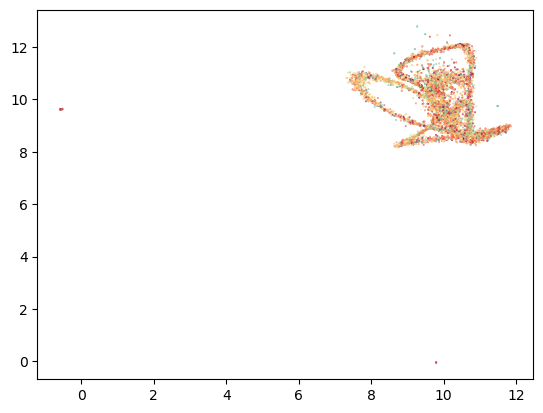

In [207]:
standard_embedding = umap.UMAP(random_state=1, n_components=num_labels).fit_transform(X)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=intent.negativereason, s=0.1, cmap='Spectral')

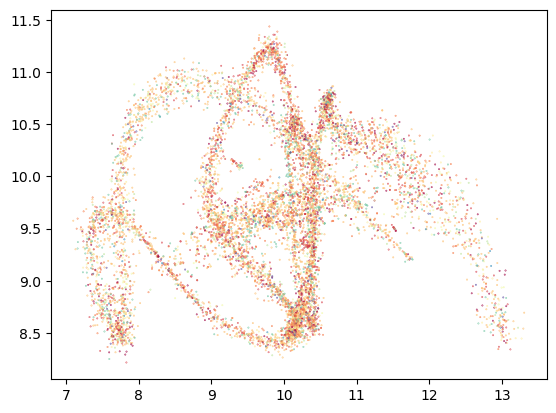

In [208]:
plt.scatter(standard_embedding[:, 2], standard_embedding[:, 3], c=intent.negativereason, s=0.1, cmap='Spectral')

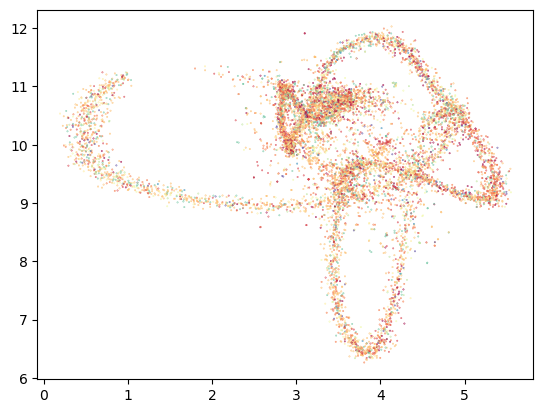

In [209]:
plt.scatter(standard_embedding[:, 4], standard_embedding[:, 5], c=intent.negativereason, s=0.1, cmap='Spectral')